[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Tiger-Quant/demos2025/blob/master/september23.ipynb)

# Basic Strategy Tutorial

This tutorial covers the following ideas:
- Using `yfinance` to load historical data
- Implementing a repeatable strategy using moving averages
- How to calculate the profits from using such a strategy
- Compartmentalization of code for reusability

## Setup

Certain Python packages are required. This installs them if we are in Colab.

In [3]:
# ------------------------------------------------------------------
# Setup Cell: Run this first to install required libraries.
# ------------------------------------------------------------------
# The '%' command runs a command within the correct environment.
# The '-q' flag makes the output "quiet" to keep the notebook clean.

RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab
if RunningInCOLAB:                                     # installs packages if in colab 
    %pip install -q yfinance pandas matplotlib-venn numpy

print("✅ Setup complete. You can now run the rest of the notebook.")

✅ Setup complete. You can now run the rest of the notebook.


Packages need to be imported to be able to actively use them. Shorter names are given for convenience's sake.

In [5]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Data Loading

`yfinance` will be used to download the data wanted. For this example, we use the `SPY`, one of the [largest exchange-traded funds](https://www.ssga.com/us/en/intermediary/capabilities/spdr-core-equity-etfs/spy-sp-500) (ETFs). Feel free to explore this strategy with other tickers.

In [8]:
data_to_use = 'SPY'

data = yf.download(data_to_use, start='2022-01-01')
data.columns = data.columns.droplevel(1)
data

C:\Users\khura\AppData\Local\Temp\ipykernel_18752\3428108342.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(data_to_use, start='2022-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2022-01-03,453.210388,453.343222,449.548364,451.872697,72668200
2022-01-04,453.058594,455.363992,451.189625,454.642960,71178700
2022-01-05,444.358887,453.466551,444.264009,452.688599,104538900
2022-01-06,443.941467,446.673770,441.560185,443.894043,86858900
2022-01-07,442.186310,445.136827,440.820159,443.950934,85111600
...,...,...,...,...,...
2025-09-23,663.210022,667.340027,661.979980,666.719971,81708900
2025-09-24,661.099976,664.609985,659.669983,664.510010,68082200
2025-09-25,658.049988,659.409973,654.409973,657.940002,89622100


### Plotting the Data

It's always a good idea to plot the data that will be used. Here, a function will be defined for ease of use later on. 
Functions are pieces of code that can be called again, allowing for easy reusability instead of copy and pasting. This is called _compartmentalization_.

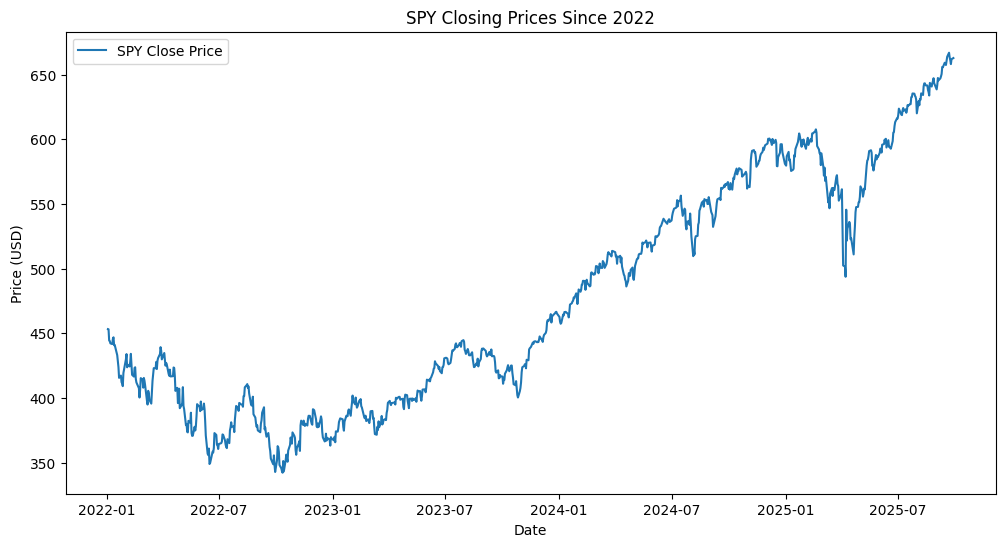

In [ ]:
# Reusable function to plot data
def plot_data(data, data_name='SPY'):
    """Plots the closing prices of the given data."""
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label=data_name +' Close Price')
    plt.title(data_name + ' Closing Prices Since 2022')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    

plot_data(data) # calling the function to plot
plt.show() # show the plot 

Bar some exceptions, `SPY` has mostly went up since 2022.

## Strategy Implementation: Simple Moving Average

The simple moving average (SMA) is a simple yet intuitive strategy. The idea is that tickers typically follow a trend (the moving average). If it goes above this trend, it is a sign that it is doing well, and one should buy. If it goes below this trend, is is a sign that it might do bad, and one should sell. Here, we'll describe the steps to programatically do this.

### Calculate SMA

The simple moving average is an average of the last $n$ datapoints. It is simple because all the datapoints are weighed the same. In this example, we use $n=50$.

In [10]:
data['SMA50'] = data['Close'].rolling(window=50).mean()
# take mean of each group of 50 rows, i.e., 
# mean for Day 1-50, mean for Day 2-51 etc.
# or just the 50-day simple moving average
data

Price,Close,High,Low,Open,Volume,SMA50
Date,,,,,,
2022-01-03,453.210388,453.343222,449.548364,451.872697,72668200,NaN
2022-01-04,453.058594,455.363992,451.189625,454.642960,71178700,NaN
2022-01-05,444.358887,453.466551,444.264009,452.688599,104538900,NaN
2022-01-06,443.941467,446.673770,441.560185,443.894043,86858900,NaN
2022-01-07,442.186310,445.136827,440.820159,443.950934,85111600,NaN
...,...,...,...,...,...,...
2025-09-23,663.210022,667.340027,661.979980,666.719971,81708900,640.579186
2025-09-24,661.099976,664.609985,659.669983,664.510010,68082200,641.392787
2025-09-25,658.049988,659.409973,654.409973,657.940002,89622100,642.103904


Rolling returns all possible consecutive windows of a desired size. We then calculate the mean, allowing us to get the average of the price over the window, which is the last 50 days.

**Note**: Notice that for the first 49 values, the moving average does not have a value. That is because there are not 49 prices before it to be able to get a rolling window (to then average). Moving averages cannot start immediately.

### Calculate Position

The position is simple. If the ticker is above the average, the position is 1, and that means we'd like to have some of the ticker. If the ticker is below the average, the position is 0, and that means we'd like to not have any ticker.

In [19]:
data['Position'] = np.where(data['Close'] > data['SMA50'], 1, 0) # 1 if above SMA, else 0
data

Price,Close,High,Low,Open,Volume,SMA50,Position
Date,,,,,,,
2022-01-03,453.210388,453.343222,449.548364,451.872697,72668200,NaN,0
2022-01-04,453.058594,455.363992,451.189625,454.642960,71178700,NaN,0
2022-01-05,444.358887,453.466551,444.264009,452.688599,104538900,NaN,0
2022-01-06,443.941467,446.673770,441.560185,443.894043,86858900,NaN,0
2022-01-07,442.186310,445.136827,440.820159,443.950934,85111600,NaN,0
...,...,...,...,...,...,...,...
2025-09-23,663.210022,667.340027,661.979980,666.719971,81708900,640.579186,1
2025-09-24,661.099976,664.609985,659.669983,664.510010,68082200,641.392787,1
2025-09-25,658.049988,659.409973,654.409973,657.940002,89622100,642.103904,1


`Numpy`'s (or np) `where` function will evaluate a Boolean(true or false) expression, and set the values accordingly if it is true or false over an array of numbers.

**Note**: Notice that for the first 49 values, the moving average does not have a value. It fails the condition set, so it gets set to 0. This makes sense, since there is still not enough data to determine if we want stock right now with this strategy.

### Calculate Signal

The signal is a sign to either buy or sell. The signal being used is whenever the position changes. If the signal is 1, it means we went from a position of 0 -> 1, or from not wanting any of the ticker to wanting it. Therefore, we should buy. The opposite occurs if the signal is -1. 0s can occur, but that means the position has not changed, so no action will be taken.

In [20]:
data['Signal'] = data['Position'].diff() # difference between current and previous row
data[data['Signal'] != 0].head() # show rows that have a signal (buy or sell)

Price,Close,High,Low,Open,Volume,SMA50,Position,Signal
Date,,,,,,,,
2022-01-03,453.210388,453.343222,449.548364,451.872697,72668200,NaN,0,NaN
2022-03-18,423.032715,423.356276,416.085595,416.827890,106345500,419.555722,1,1.0
2022-04-11,418.655060,423.489489,418.150680,422.642496,89770500,419.390375,0,-1.0
2022-04-13,421.881195,422.642513,416.675604,416.856422,74070400,419.038949,1,1.0
2022-04-14,416.628021,423.232556,416.523323,422.109573,97869500,418.693618,0,-1.0


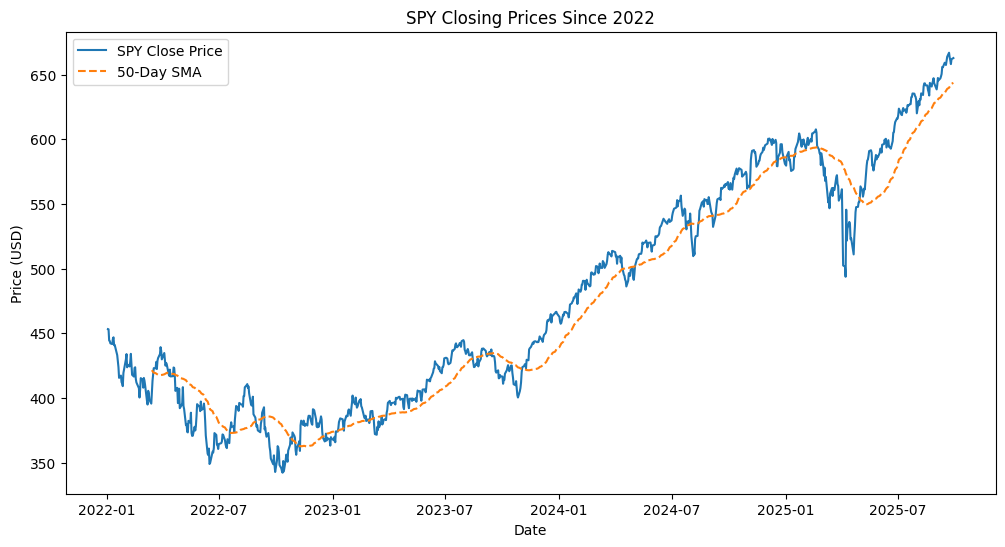

In [21]:
plot_data(data)
plt.plot(data['SMA50'], label='50-Day SMA', linestyle='--')
plt.legend() # show legend
plt.show()

#### Plot Signals

We can plot the signals to get a visual intuition of the strategy.

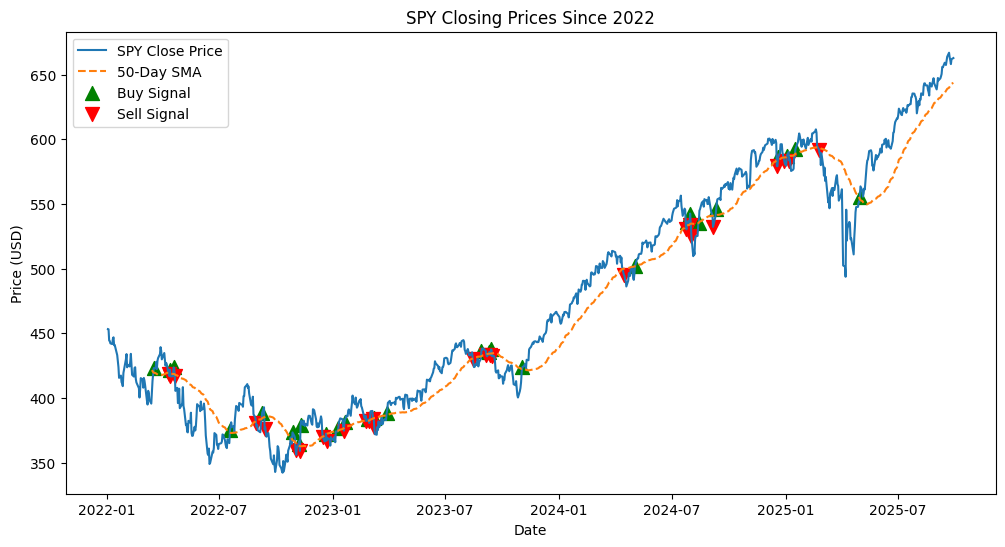

In [ ]:
plot_data(data)
plt.plot(data['SMA50'], label='50-Day SMA', linestyle='--')

buy_signal = (data['Signal'] == 1.0) # where signal is 1
plt.scatter(data.index[buy_signal], 
            data['Close'][buy_signal],
            label='Buy Signal', marker='^', color='green', s=100)

sell_signal = (data['Signal'] == -1.0) # where signal is -1
plt.scatter(data.index[sell_signal], 
            data['Close'][sell_signal],
            label='Sell Signal', marker='v', color='red', s=100)

plt.legend()
plt.show()

## Calculating Strategy Returns


To calculate how our strategy would do, we find the buy signal, buy some amount at the current price, and then sell at the next sell signal.

In [ ]:
def calculate_returns(quantity, data, buy_signal, sell_signal):
    """Calculate the returns of a trading strategy based on buy and sell signals."""
    
    total_profit = 0
    total_money_in = 0
    for time, buy_row in data[buy_signal].iterrows(): # iterate over every buy signal
        buy_price = buy_row['Close']
        sell_trades = data[(data.index > time) & sell_signal]
        # check for a sell signal after the buy signal

        if not sell_trades.empty: # could potentially not have a sell signal, like at the end
            sell_price = (sell_trades.iloc[0])['Close'] # first sell signal after buy signal

            profit = (sell_price - buy_price) * quantity
            total_money_in = total_money_in + (buy_price * quantity)
            print(f"Bought at ${buy_price:.2f}. Sold at ${sell_price:.2f}, Profit: ${profit:.2f}")
            total_profit = total_profit + profit
        else:
            print(f"Bought at ${buy_price:.2f}, No sell signal found.")
    return total_profit, total_money_in


With the way this function has been coded, this can calculate the returns of virtually any strategy that is based on buy and sell signals.

In [45]:
profit, total_money_in = calculate_returns(1, data, buy_signal, sell_signal)

print(f"Total Profit: ${profit:.2f}, Money Invested: ${total_money_in:.2f}, Return on Investment: {(profit/total_money_in)*100:.2f}%")

Bought at $423.03. Sold at $418.66, Profit: $-4.38
Bought at $421.88. Sold at $416.63, Profit: $-5.25
Bought at $423.53. Sold at $416.88, Profit: $-6.64
Bought at $374.92. Sold at $380.60, Profit: $5.68
Bought at $388.62. Sold at $375.71, Profit: $-12.90
Bought at $373.34. Sold at $359.76, Profit: $-13.58
Bought at $364.64. Sold at $359.05, Profit: $-5.59
Bought at $378.78. Sold at $369.51, Profit: $-9.27
Bought at $372.37. Sold at $367.05, Profit: $-5.31
Bought at $376.56. Sold at $374.69, Profit: $-1.87
Bought at $381.67. Sold at $382.15, Profit: $0.48
Bought at $383.45. Sold at $382.04, Profit: $-1.42
Bought at $383.53. Sold at $383.97, Profit: $0.44
Bought at $384.60. Sold at $377.51, Profit: $-7.10
Bought at $388.42. Sold at $430.21, Profit: $41.79
Bought at $436.31. Sold at $433.45, Profit: $-2.86
Bought at $435.62. Sold at $433.23, Profit: $-2.39
Bought at $437.47. Sold at $432.20, Profit: $-5.27
Bought at $423.74. Sold at $495.27, Profit: $71.53
Bought at $501.98. Sold at $530.

As shown, a profit technically was made. However, an ROI of less than a percent is not the best. However, it is repeatable and intuitive.